# Projeto de Machine Learning | Processamento Natural de Linguagem

> Jean Sanandrez | Fabricio Neri | Luiza Valezim

O primeiro passo que precisaremos fazer é importar as principais bibliotecas que serão utilizadas no processo. O tensorflow e o sklearn são extremamente importantes nos processos de aplicação de ML no projeto.

In [ ]:
!pip install tensorflow_text --quiet
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text  # Registers the ops.
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pickle
from tensorflow import keras

# Leitura dos dados

Os dados são originários de uma competição do Kaggle, em que você precisa criar um modelo que relacione uma âncora, um contexto e uma frase e retorne em um score de 0 a 1.0 o quanto a frase e a âncora estão relacionados através do mesmo contexto. 

O link da competição pode ser acessado a seguir: [clique aqui para ser direcionado ](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/data?select=train.csv)

Os dados dados de treino originários possuem um total de 37 mil linhas, contudo, se tornava inviável processar todos esses dados pois o tempo de processamento ultrapassava 5h para cada ação, então fizemos uma amostragem dos dados.

Mantivemos apenas as linhas que possuíam contextos com frequências mais significativas. Dois contextos em específicos possuiam somados 70% da frequência dos dados, então mantivemos os dois.

Caso queira verificar o funcionamento do projeto com os dados totais, iremos enviar também os dados originais.

In [18]:
import pandas as pd
import numpy as np
train = pd.read_csv("train_filter.csv")
test = pd.read_csv("test_filter.csv")

Abaixo é possível verificar as principais colunas da tabela de treino. Apenas a coluna de ID não possui valor para um futuro modelo. Além disso, não é possível realizar uma análise exploratória propriamente dita porque por se tratar de um projeto de NLP, e em específico o batimento de âncora e target por um contexto, frequência de palavras em frases e etc, métricas importantes em NLP, não fazem tanto sentido neste caso, porque tudo depende do contexto.

In [19]:
train

,id,anchor,target,context,score
0,6bdd1d05ffa3401e,abatement,emission abatement,H04,0.50
1,a937ae580ea4bd97,achieve authentication,achieve access,H04,0.75
2,ea154b802bebc48a,achieve authentication,achieve authentication accuracy,H04,0.50
3,24eda11bf0665917,achieve authentication,achieve authorization,H04,0.75
4,14c027729175aedd,achieve authentication,achieve goal,H04,0.00
...,...,...,...,...,...
3049,61350d231d52c186,wire grid polarization,polarization,H04,0.50
3050,59c0d33ccfb4f873,wire grid polarization,polarizing,H04,0.50
3051,46017862b2545572,wire grid polarization,wire grid,H04,0.25
3052,b4b17a1795a5ecc6,wire grid polarization,wire grid polarizers,H04,1.00


Vamos separar o dataset de treino e treino e teste, isso vai ajudar a fazer a validação dos dados do modelo.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train[['context', 'anchor', 'target']], train[['score']], test_size=0.20, random_state=42)

In [21]:
context_train = X_train.context.values
context_test = X_test.context.values

In [22]:
anchor_train = X_train.anchor.values
anchor_train

array(['channel vectors', 'ftir spectrometer', 'image signal generation',
       ..., 'hear aid parameters', 'instruction processing', 'el display'],
      dtype=object)

In [23]:
target_train = X_train.target.values
target_train

array(['channel coefficient vector', 'scientific instrument',
       'reverse image', ..., 'hear aid', 'data processing instruction',
       'organic el display'], dtype=object)

In [24]:
anchor_test = X_test.anchor.values
anchor_test

array(['cable securing', 'connected means', 'imaging axis',
       'connected means', 'pulse width modulated control',
       'cathode layer', 'imaging axis', 'receiver shaft',
       'color difference signal', 'steering matrices', 'reduction factor',
       'sheet supply roller', 'browsers', 'reduction factor',
       'connected means', 'noncollinear', 'content analysis',
       'apply to requests', 'blooming drains',
       'display different pictures', 'neural stimulation', 'page file',
       'imaging axis', 'cable securing', 'decompressor', 'based method',
       'steering matrices', 'material item', 'instruction processing',
       'page file', 'display different pictures', 'el display',
       'place to set', 'channel vectors', 'determine from analysis',
       'multiplexed data', 'sheet supply roller', 'form as body',
       'request buffer', 'reflection type liquid crystal display',
       'reflection type liquid crystal display', 'video lines', 'key arm',
       'operator ide

In [25]:
target_test = X_test.target.values
target_test

array(['cable', 'distribution box', 'optical lens axis',
       'rectifying elements', 'controller module', 'cathode substrate',
       'microscope system', 'master shaft', 'chrominance',
       'divergent beams', 'crest factor reduction', 'sheet transport',
       'brochure templates', 'strength reduction factor',
       'coupled transistors', 'non real numbers',
       'video content analysis', 'request leave', 'blooming flower',
       'display multiple pictures', 'neurological stimulation',
       'confidential file', 'observation axis', 'unit folder',
       'computer terminal', 'provide computer based method',
       'plurality of steering matrices', 'wire material',
       'instruction processing unit', 'page id', 'different display',
       'illuminable', 'crowded place', 'channel response matrices',
       'determine by gc analysis', 'data warehousing',
       'sheet transport rollers', 'inner and outer surfaces',
       'network request buffer', 'reflective mode lcd crystal d

In [26]:
hub_url = "https://tfhub.dev/google/sentence-t5/st5-base/1"

In [27]:
def aplica_t5(text):
    tensor_list = []

    not_finish = True

    i = 0
    while not_finish:
        tensor_list.append(encoder(text[i:i+1])[0][0])
        if i == len(text) - 1:
            not_finish = False
        i +=1
        print(i)
    print("Fim")
  
    return tensor_list

## Aplicando o sentence t5 

Agora vamos aplicar o sentence t5, um encoder de texto, em cada uma das nossas colunas de texto. Isso fará com que as sentenças e paragráfos mapeados se tornem um vetor de dimensão 768. Isso terá uma extrema importância pros modelos pois eles não conseguiriam entender um texto em seu formato original.

In [28]:
encoder = hub.KerasLayer(hub_url)

In [30]:
tensor_list_anchor_train = [item.numpy() for item in aplica_t5(anchor_train)]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [31]:
tensor_list_target_train = [item.numpy() for item in aplica_t5(target_train)]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [32]:
tensor_list_anchor_test = [item.numpy() for item in aplica_t5(anchor_test)]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [33]:
tensor_list_target_test = [item.numpy() for item in aplica_t5(target_test)]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


Agora que já fizemos todo o processamento dos dados, podemos juntá-los novamente e iniciar o processo de aplicação de modelos! Vamos primeiro verificar como ficaria um dataset com os nossos dados pré processados!

In [34]:
df_dict_train = {'anchor': tensor_list_anchor_train, 'target': tensor_list_target_train, 'context': context_train} 
df_train_pre_process = pd.DataFrame(df_dict_train)

In [35]:
df_dict_test = {'anchor': tensor_list_anchor_test, 'target': tensor_list_target_test, 'context': context_test} 
df_test_pre_process = pd.DataFrame(df_dict_test)

In [36]:
df_train_pre_process.head(10)

,anchor,target,context
0,"[-0.0041455897, 0.008629801, -0.0015985373, 0....","[-0.005752636, 0.014921856, -0.026139496, 0.02...",H04
1,"[-0.017522456, -0.009105446, 0.011088807, -0.0...","[-0.026981762, -0.0037352955, 0.0013800176, 0....",G02
2,"[-0.004556078, 0.00073000207, 0.011585892, 0.0...","[-0.005817436, 0.015859123, 0.03723751, 0.0361...",H04
3,"[-0.0024025522, 0.0023999435, 1.757596e-05, 0....","[-0.0044816523, -0.0026907905, 0.00043605364, ...",H04
4,"[-0.029380755, 0.0067394325, 0.02307278, 0.027...","[-0.01638283, -0.002532923, 0.01957229, 0.0393...",H04
5,"[-0.026818106, -0.04342738, 0.012493371, 0.014...","[-0.028035538, -0.025664665, 0.018312432, 0.02...",H04
6,"[-0.013730726, 0.043138575, -0.019898336, 0.02...","[-0.024303623, -0.0037116008, -0.022282429, -0...",H04
7,"[-0.007624526, 0.049074385, 0.009555302, 0.007...","[3.232523e-05, 0.030661648, 0.0046217744, 0.00...",G02
8,"[-0.021826955, 0.04106771, 0.020565022, 0.0339...","[-0.021145925, 0.042495552, 0.006259948, 0.044...",H04
9,"[0.0017017433, 0.023156075, -0.0060733515, 0.0...","[0.001962241, 0.016862769, 0.0026229185, 0.027...",H04


Opa! Foi esquecido de realizar um encoder do contexto, isso porque precisamos traduzir para os modelos o que o H04 e G02 significam. Além disso, precisaremos concatenar a âncora e o target. Podemos criar uma pipeline para o processamento da coluna de context.

In [37]:
enc = OrdinalEncoder()

In [38]:
cat_pipeline = Pipeline([
    ('cat_encoder', enc),
])

In [39]:
cat_attribs = ['context']

Apesar de só precisarmos processar uma coluna, podemos criar uma pipeline completa para em caso de futuras interações precisarmos de mais processos de mudança dos dados.

In [40]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ('cat', cat_pipeline, cat_attribs),
])

In [41]:
train_prepared = full_pipeline.fit_transform(df_train_pre_process)
test_prepared = full_pipeline.fit_transform(df_test_pre_process)

Agora que temos todas as colunas processadas, podemos concatená-las para iniciar a aplicação do modelo!

In [42]:
x_train = np.concatenate((tensor_list_anchor_train, tensor_list_target_train, train_prepared), axis = 1)

In [43]:
x_test = np.concatenate((tensor_list_anchor_test, tensor_list_target_test, test_prepared), axis = 1)

# Encontrando o melhor modelo

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Linear Regression
A regressão linear é uma análise utilizada para prever o valor de uma varíavel (chamada de variável dependente) com base no valor de outra variável (variável independente). Essa forma de análise estima os coeficientes da equação linear, envolvendo uma ou mais variáveis independentes que melhor predizem o valor da variável dependente. O que a regressão linear faz é ajustar uma linha reta ou superfície que minimiza as discrepâncias entre os valores de saída previstos e reais, e geralmente as calculadoras de regressão linear usam o método de “mínimos quadrados” para descobrir a linha de melhor ajuste. Graças a essa simplicidade e facilidade na interpretação dos dados, esse é um método muito utilizado em diversas áreas, como biologia, ciências sociais, etc...

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
clf_linear_regression = LinearRegression()
clf_linear_regression.fit(x_train,y_train)

LinearRegression()

Vamos verificar o resultado do modelo com um cross validation!

In [ ]:
scores_linear_regression = cross_val_score(
    clf_linear_regression,
    x_train,
    y_train,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

scores_linear_regression

array([-3.25737763e+09, -3.12316664e-01, -1.96110045e+09])

O resultado do cross validation sai negativo por uma questão de interpretação. Se quisermos enxergar da maneira correta, é preciso inverter o sinal.

# Bayesian Ridge
Agora explicando um pouco sobre o método Bayesian Ridge, o objetivo dessa regressão é de determinar a probabilidade anterior para os parâmetros do modelo, em vez de identificar o "melhor" valor desses parâmetros. Ou seja, ele permite de um mecânismo atuar mesmo quando os dados são insuficientes ou mal distribuídos ao realizar uma regressão linear usando distruidores de probabilidade ao invés de pontos estimados. 

Para encontrarmos os valores probabilísticos, utilizamos a seguinte fórmula:    
$ p(y⏐X,w,α)=N(y⏐Xw,α) $

In [ ]:
clf_bayesian_ridge = BayesianRidge()
clf_bayesian_ridge.fit(x_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BayesianRidge()

In [ ]:
scores_bayesian_ridge = cross_val_score(
    clf_bayesian_ridge,
    x_train,
    y_train,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

scores_bayesian_ridge

array([-0.22917419, -0.23166696, -0.23836405])

# RandomForest
Como o próprio nome diz, essa regressão cria árvores de decisão (decision trees) que são definidas pelas suas variáveis aleatórias e ao final formam uma floresta aleatória. Para entendermos esse método, primeiro precisamos entender o que seriam as decision trees. Basicamente o algoritmo criará uma estrutura similar a um fluxograma, com “nós” onde uma condição é verificada, e, se atendida, o fluxo segue por um ramo, caso contrário, por outro, sempre levando ao próximo nó, até a finalização da árvore.

Agora já familizarizados com os conceitos, você deve estar se perguntando como ele funciona, pois bem, primeiro temos as seleções das amostras, as quais também são realizadas de forma aleatória ao coletar aleatoriamente dos dados de treinamento. Nesta etapa é utilizado o bootstrap, que é um método de reamostragem onde as amostras selecionadas podem ser repetidas na seleção. Com esta primeira seleção de amostras será construída a primeira árvore de decisão. Em seguida, o algoritmo de entropia ou o índice Gini, escolherá a melhor variável para compor o nó raiz, variando de acordo com o método utilizado. Vale lembrar que esse cálculo não acontece na totalidade dos dados de treinamento, e sim só em uma parcela deles. Para escolha da variável do próximo nó, novamente serão escolhidas duas (ou mais) variáveis, excluindo as já selecionadas anteriormente, e o processo de escolha se repetirá.

Por fim, vale ressaltar que esse não é o melhor método para construção de uma árvore de decisão, já que o algoritmo pode escolher as duas piores variáveis em sua primeira seleção. Entretanto, essa é uma prática também poderosa já que, por ser aleatória, acaba evitando o overfitting.

In [ ]:
clf_random_forest = RandomForestRegressor(max_depth=2)
clf_random_forest.fit(x_train,y_train)

<ipython-input-33-9172d54e5e98>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_random_forest.fit(x_train,y_train)


RandomForestRegressor(max_depth=2)

In [ ]:
scores_random_forest = cross_val_score(
    clf_random_forest,
    x_train,
    y_train,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

scores_random_forest

array([-0.24681879, -0.25182797, -0.25814291])

# Kernel Ridge

Os modelos de regressão de Kernel Ridge são modelos de regressão não paramétricos capazes de modelar relacionamentos lineares e não lineares entre variáveis preditoras e resultados. Entretanto, seus resultados podem ser muito sensíveis às escolhas de hiperparâmetros passados. Assim, a regressão funciona a partir da combinação da regressão de Ridge (mínimos quadrados lineares com regularização de norma l2) com o truque do kernel. Dessa forma, ele aprende uma função linear no espaço induzido pelo respectivo kernel e pelos dados. Vale lembrar que para kernels não lineares isso corresponde a uma função não linear no espaço original.

In [ ]:
from sklearn.kernel_ridge import KernelRidge

In [ ]:
clf_kernel_ridge = KernelRidge()
clf_kernel_ridge.fit(x_train,y_train)

KernelRidge()

In [ ]:
scores_kernel_ridge = cross_val_score(
    clf_kernel_ridge,
    x_train,
    y_train,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

scores_kernel_ridge

array([-0.2293451 , -0.2317493 , -0.23842658])

# ElasticNet

O ElasticNet é um método de regressão regularizada que combina linearmente as penalidades L1 e L2 dos métodos Lasso e Ridge, ao aprender com suas deficiências o que melhorar na regularização de modelos estatísticos. Isso ocorre, pois a regressão melhora as limitações do Lasso, ou seja, onde o Lasso pega algumas amostras para dados de alta dimensão. O procedimento de ElasticNet prevê a inclusão de “n” número de variáveis até a saturação. Se as variáveis são grupos altamente correlacionados, Lasso tende a escolher uma variável de tais grupos e ignorar o resto completamente. Dessa forma, essa técnica é mais apropriada quando os dados dimensionais são maiores que o número de amostras usadas. Agrupamentos e seleção de variáveis são os principais papéis da técnica.

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
clf_elastic_net = ElasticNet()
clf_elastic_net.fit(x_train,y_train)

ElasticNet()

In [ ]:
scores_elastic_net = cross_val_score(
    clf_elastic_net,
    x_train,
    y_train,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

scores_elastic_net

array([-0.2603032 , -0.26550769, -0.2706656 ])

# SVM

SVM, também conhecido como Support Vector Machine, é um algoritmo que encontra um hiperplano em um espaço N-dimensional (N — o número de recursos) que classifica distintamente os pontos de dados. Primeiramente é necessário encontrar um hiperplano que realiza a distinção para criar duas classes de pontos. Nosso objetivo ao fazer esse agrupamento é de encontrar um plano que tenha a margem máxima, ou seja, a distância máxima entre os pontos de dados de ambas as classes. Ao maximizar a distância da margem fornecemos algum reforço para que pontos de dados futuros possam ser classificados com mais confiança.

<img src="https://miro.medium.com/max/720/0*ecA4Ls8kBYSM5nza.webp" alt="Alternative text" />

Os vetores de suporte dessa imagens são pontos de dados que estão mais próximos do hiperplano e que influenciam na posição e na orientação do hiperplano. Usando esses vetores de suporte, maximizamos a margem do classificador. Se excluíssemos esses vetores de suporte, alterará a posição do hiperplano e não conseguiríamos construir nosso SVM.

In [ ]:
from sklearn.svm import SVR

In [ ]:
clf_SVR = SVR()
clf_SVR.fit(x_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [ ]:
scores_SVR = cross_val_score(
    clf_SVR,
    x_train,
    y_train,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

scores_SVR

array([-0.22080178, -0.22301181, -0.23011978])

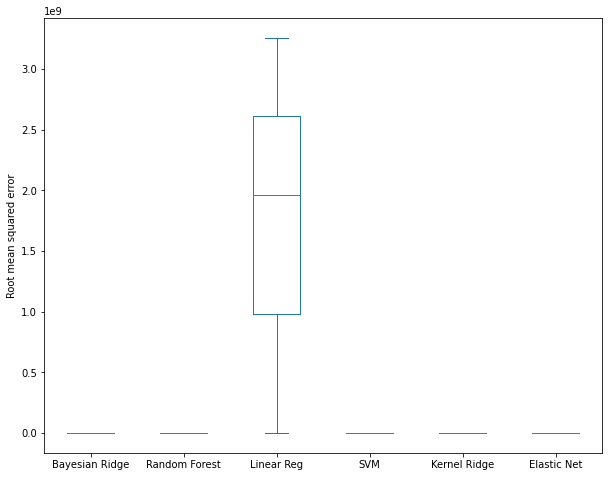

In [ ]:
pd.DataFrame({
    'Bayesian Ridge': -scores_bayesian_ridge,
    'Random Forest': -scores_random_forest,
    'Linear Reg' : -scores_linear_regression,
    'SVM': -scores_SVR,
    'Kernel Ridge': -scores_kernel_ridge,
    'Elastic Net': -scores_elastic_net
}).plot.box(
    xlabel='Regressors',
    ylabel=r'Root mean squared error',
    figsize=(10, 8),
);


Vamos retirar o linear reg porque no plot acima podemos perceber que ele realmente foi muito ruim e isso está atrapalhando a visualização dos demais.

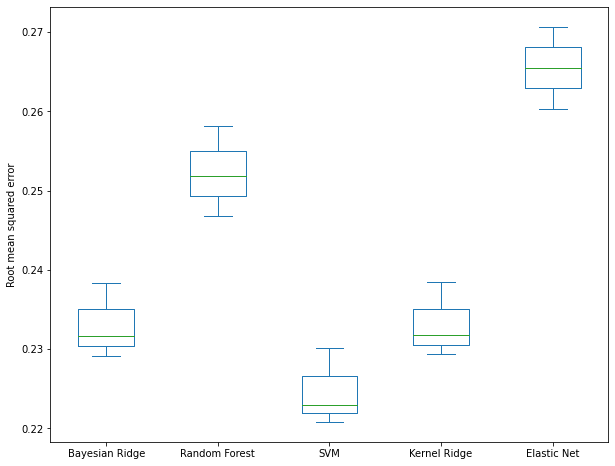

In [ ]:
pd.DataFrame({
    'Bayesian Ridge': -scores_bayesian_ridge,
    'Random Forest': -scores_random_forest,
    'SVM': -scores_SVR,
    'Kernel Ridge': -scores_kernel_ridge,
    'Elastic Net': -scores_elastic_net
}).plot.box(
    xlabel='Regressors',
    ylabel=r'Root mean squared error',
    figsize=(10, 8),
);

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

O gráfico deixa claro que os três melhores modelos foram a SVM, o Bayesian Ridge e o Kernel Ridge, e que entre o Kernel Ridge e o Bayesian Ridge não houveram grandes diferenças. Por isso, vamos tentar melhorar os resultados da SVM e do Bayesian Ridge através da hiperparametrização.

# Hiperparametrizando os melhores modelos

In [ ]:
pipe_bayesian_ridge = Pipeline([
    ('clf', clf_bayesian_ridge)
])

params = {
    'clf__alpha_1': [10, 100, 1000], 
    'clf__alpha_2': [1e-14, 1e-11, 1e-13], 
    'clf__lambda_1': [1e-13, 1e-12, 1e-14], 
    'clf__lambda_2': [1e-2,1e-1, 1, 10] 
}

Na célula acima estão valores especificos porque fizemos varias vezes o grindsearch, contudo, colocando varios valores de uma vez fazia com que o modelo rodasse por horas e horas, tornando inviável. Por isso colocavamos diversos intervalos até aproximar de um melhor intervalo como está acima.

In [ ]:
clf_br = GridSearchCV(pipe_bayesian_ridge, params, cv=2, scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs=-1, verbose=3)
clf_br = clf_br.fit(x_train, y_train)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
clf_br.best_params_

{'clf__alpha_1': 10,
 'clf__alpha_2': 1e-11,
 'clf__lambda_1': 1e-12,
 'clf__lambda_2': 1}

In [ ]:
y_pred = clf_br.predict(x_train)

In [ ]:
clf_bayesian_ridge_mse_train = mean_squared_error(y_train, y_pred)
clf_bayesian_ridge_rmse_train = np.sqrt(clf_bayesian_ridge_mse_train)
print('Bayesian Ridge [conjunto de treino]: RMSE = {:.2f}'.format(clf_bayesian_ridge_rmse_train))

Bayesian Ridge [conjunto de treino]: RMSE = 0.21


In [ ]:
scores_Bayesian_ridge_hiper = cross_val_score(
    clf_br,
    x_train,
    y_train,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

scores_Bayesian_ridge_hiper

array([-0.22908947, -0.23132428, -0.23819551])

Vamos tentar fazer também a hiperparametrização para a SVM, já que foi também um dos melhores modelos

In [ ]:
pipe_SVM = Pipeline([
    ('clf', clf_SVR)
])

params_svm = {
    'clf__kernel': ['poly'], #fizemos grindsearchs antes e o melhor foi poly, entao reduzimos as opções para aumentar dos demais
    'clf__degree': [8, 9, 10, 11, 12, 18], #os valores estao altos pois ja percebemos que sempre selecionava os altos
    'clf__coef0': [0.0, 1.0],
    'clf__C': [10.0, 5.0, 100.0, 200.0],
    'clf__epsilon': [0.1, 0.5, 0.7]
}

In [ ]:
clf_svm = GridSearchCV(pipe_SVM, params_svm, cv=2, scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs=-1, verbose=3)
clf_svm = clf_svm.fit(x_train, y_train)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
clf_svm.best_params_

{'clf__C': 100.0,
 'clf__coef0': 0.0,
 'clf__degree': 12,
 'clf__epsilon': 0.1,
 'clf__kernel': 'poly'}

In [ ]:
y_pred = clf_svm.predict(x_train)

In [ ]:
clf_SVR_mse_train = mean_squared_error(y_train, y_pred)
clf_SVR_rmse_train = np.sqrt(clf_SVR_mse_train)
print('SVR [conjunto de treino]: RMSE = {:.2f}'.format(clf_SVR_rmse_train))

SVR [conjunto de treino]: RMSE = 0.09


Opa! Aparentemente esse foi o nosso melhor resultado até agora! Parece que realmente a hiperparametrização funcionou! =) 

Vamos verificar no teste.

In [ ]:
y_pred = clf_svm.predict(x_test)
clf_SVR_mse_test = mean_squared_error(y_test, y_pred)
clf_SVR_rmse_test = np.sqrt(clf_SVR_mse_test)
print('SVR [conjunto de teste]: RMSE = {:.2f}'.format(clf_SVR_rmse_test))

SVR [conjunto de teste]: RMSE = 0.19


O resultado não piorou drasticamente. A queda é plausível, não necessariamente significa um overfitting. Além disso se manteve como o melhor resultado até o momento dentre todos os modelos testados.

Vamos testar um crossvalidation dos modelos ajustados para verificar o novo desempenho generalizando o dataset.

In [ ]:
scores_SVR_hiper = cross_val_score(
    clf_svm,
    x_train,
    y_train,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

scores_SVR_hiper

array([-0.20598192, -0.20803719, -0.21436914])

Vamos verificar os resultados:

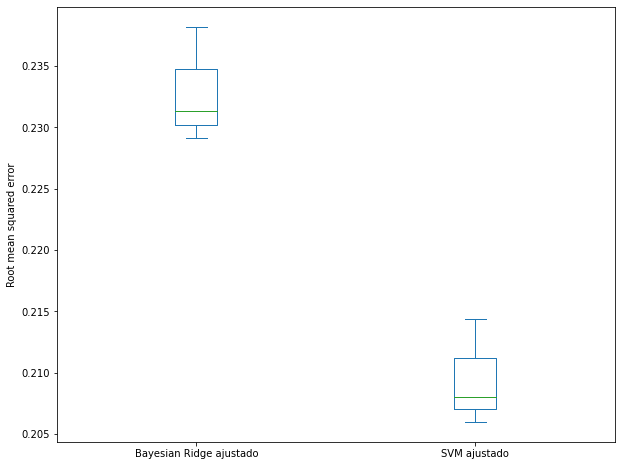

In [ ]:
pd.DataFrame({
    'Bayesian Ridge ajustado': -scores_Bayesian_ridge_hiper,
    'SVM ajustado': -scores_SVR_hiper    
}).plot.box(
    xlabel='Regressors',
    ylabel=r'Root mean squared error',
    figsize=(10, 8),
);

O modelo bayesiano praticamente não teve melhoras, mas o SVM teve uma melhora em relação como estava antes, fazendo dele sem dúvida o melhor até o momento.

___

## Redes Neurais

Agora vamos tentar uma nova estratégia, vamos fazer o uso das redes neurais para entender se elas produzem um efeito melhor do que os modelos de Machine Learning previamente utilizados.

#### Rede Neural | Dense layers

vamos tentar implementar um modelo mais simples de Redes Neurais, um só com camadas Densas

In [44]:
Dense = keras.models.Sequential([
    keras.layers.InputLayer(x_train.shape[1]),
    keras.layers.Dense(500),
    keras.layers.Dense(50),
    keras.layers.Dense(5)
])
Dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               769000    
                                                                 
 dense_1 (Dense)             (None, 50)                25050     
                                                                 
 dense_2 (Dense)             (None, 5)                 255       
                                                                 
Total params: 794,305
Trainable params: 794,305
Non-trainable params: 0
_________________________________________________________________


In [45]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
Dense.compile(loss="mse", optimizer=optimizer)
Dense.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_test, y_test),
)

Epoch 1/20
5/5 [==============================] - 2s 136ms/step - loss: 2.8509 - val_loss: 2.1586
Epoch 2/20
5/5 [==============================] - 0s 54ms/step - loss: 1.0213 - val_loss: 0.9934
Epoch 3/20
5/5 [==============================] - 0s 55ms/step - loss: 0.4633 - val_loss: 0.2407
Epoch 4/20
5/5 [==============================] - 0s 55ms/step - loss: 0.3163 - val_loss: 0.2308
Epoch 5/20
5/5 [==============================] - 0s 50ms/step - loss: 0.1395 - val_loss: 0.1080
Epoch 6/20
5/5 [==============================] - 0s 49ms/step - loss: 0.1160 - val_loss: 0.1126
Epoch 7/20
5/5 [==============================] - 0s 56ms/step - loss: 0.0922 - val_loss: 0.0639
Epoch 8/20
5/5 [==============================] - 0s 58ms/step - loss: 0.0759 - val_loss: 0.0684
Epoch 9/20
5/5 [==============================] - 0s 55ms/step - loss: 0.0794 - val_loss: 0.0596
Epoch 10/20
5/5 [==============================] - 0s 54ms/step - loss: 0.0660 - val_loss: 0.0585
Epoch 11/20
5/5 [===========

In [46]:
Dense_loss_train= Dense.evaluate(x_train,y_train)
Dense_loss_test= Dense.evaluate(x_test,y_test)
print(f'Rede Neural: Dense [conjunto de train]: RMSE = {Dense_loss_train**(1/2)}')
print(f'Rede Neural: Dense [conjunto de teste]: RMSE = {Dense_loss_test**(1/2)}')

20/20 [==============================] - 0s 5ms/step - loss: 0.0527
Rede Neural: Dense [conjunto de train]: RMSE = 0.2383128833097371
Rede Neural: Dense [conjunto de teste]: RMSE = 0.22960037765449026


### Novo Approach

  Ao invés de concatenar **anchor**, **target** e **context**, concatenamos **anchor** com **context** e **target** com **context**, e no final ao passar os dados por um modelos fazemos um produto vetorial entre eles.

In [47]:
x_anchor_train, x_target_train, x_context_train = x_train[:,0:768], x_train[:,768:1536], x_train[:,1536:1536]
x_anchor_test, x_target_test, x_context_test = x_test[:,0:768], x_test[:,768:1536], x_test[:,1536:1536]

x_train_novo = [x_anchor_train, x_target_train, x_context_train]
x_test_novo = [x_anchor_test, x_target_test, x_context_test]

#### Rede Neural | Modelo do Novo **Approach**

In [48]:
input1 = keras.layers.Input(x_anchor_train.shape[1])
input2 = keras.layers.Input(x_target_train.shape[1])
context = keras.layers.Input(x_context_train.shape[1])
c1 = keras.layers.Concatenate()([input1,context])
c2 = keras.layers.Concatenate()([input2,context])
modelzinho = keras.models.Sequential([
    keras.layers.Dense(500),
    keras.layers.Dense(50),
    keras.layers.Dense(5)
])
x1 =modelzinho(c1)
x2 = modelzinho(c2)
n1 = keras.layers.UnitNormalization()(x1)
n2 = keras.layers.UnitNormalization()(x2)
p = keras.layers.Dot(axes=1)([n1,n2])
s = keras.layers.Softmax()(p)
big_model = keras.Model(inputs =[input1,input2,context]  , outputs=[s]  )
big_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 0)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 768)          0           ['input_2[0][0]',                
                                                                  'input_4[0][0]']            

In [53]:
keras.utils.plot_model(big_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [54]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
big_model.compile(loss="mse", optimizer=optimizer)
big_model.fit(
    x_train_novo,
    y_train,
    epochs=50,
    batch_size=512,
    validation_data=(x_test_novo, y_test),
)

Epoch 1/50
5/5 [==============================] - 1s 103ms/step - loss: 0.4784 - val_loss: 0.4973
Epoch 2/50
5/5 [==============================] - 0s 40ms/step - loss: 0.4784 - val_loss: 0.4973
Epoch 3/50
5/5 [==============================] - 0s 52ms/step - loss: 0.4784 - val_loss: 0.4973
Epoch 4/50
5/5 [==============================] - 0s 48ms/step - loss: 0.4784 - val_loss: 0.4973
Epoch 5/50
5/5 [==============================] - 0s 45ms/step - loss: 0.4784 - val_loss: 0.4973
Epoch 6/50
5/5 [==============================] - 0s 45ms/step - loss: 0.4784 - val_loss: 0.4973
Epoch 7/50
5/5 [==============================] - 0s 50ms/step - loss: 0.4784 - val_loss: 0.4973
Epoch 8/50
5/5 [==============================] - 0s 58ms/step - loss: 0.4784 - val_loss: 0.4973
Epoch 9/50
5/5 [==============================] - 0s 53ms/step - loss: 0.4784 - val_loss: 0.4973
Epoch 10/50
5/5 [==============================] - 0s 49ms/step - loss: 0.4784 - val_loss: 0.4973
Epoch 11/50
5/5 [===========

In [55]:
big_model_loss_train= big_model.evaluate(x_train_novo,y_train)
big_model_loss_test= big_model.evaluate(x_test_novo,y_test)
print(f'Rede Neural: Big_model [conjunto de train]: RMSE = {big_model_loss_train**(1/2)}')
print(f'Rede Neural: Big_model [conjunto de teste]: RMSE = {big_model_loss_test**(1/2)}')

20/20 [==============================] - 0s 5ms/step - loss: 0.4973
Rede Neural: Big_model [conjunto de train]: RMSE = 0.6916702111471273
Rede Neural: Big_model [conjunto de teste]: RMSE = 0.7052236602297173


#### Rede Neural | Pivotando o modelo

Como podemos ver, o modelo de Rede Neural anterior não teve um **RMSE** muito bom quando comparando a primeira tentativa de rede neural. Fazer a separação do **target** e **anchor** e junto do contexto e depois juntart tudo com produto vetorial não pareceu uma boa ideia, nesse sentido, vamos voltar a primeira estratégia de utilizar o **target**, **anchor** e **context** todos concatenados e tentar melhorar o primeiro modelo de Rede Neural que tentamos

**OBS**: Foi tentado utlizar outras camadas com **RNN** e **LSTM**, mas por motivos de recurso computacional, não deu para ser implemetado

In [72]:
input = keras.layers.Input((x_train.shape[1]))
NN = keras.models.Sequential([
    keras.layers.Dropout(0.25),
    keras.layers.Dense(5000),
    keras.layers.Dropout(0.35),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1000),
    keras.layers.Dense(750),
    keras.layers.Dense(500, activation="tanh"),
    keras.layers.Dropout(0.45),
    keras.layers.Dense(430),
    keras.layers.Dense(222),
    keras.layers.Dense(100),
    keras.layers.Dropout(0.45),
    keras.layers.Dense(5),
    keras.layers.GaussianNoise(stddev=1),
    keras.layers.Dropout(0.50),
    keras.layers.Dense(100),
])
X = NN(input)
new_model = keras.Model(inputs=input, outputs=[X])
new_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1537)]            0         
                                                                 
 sequential_8 (Sequential)   (None, 100)               14171767  
                                                                 
Total params: 14,171,767
Trainable params: 14,161,767
Non-trainable params: 10,000
_________________________________________________________________


In [75]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
new_model.compile(loss="mse", optimizer=optimizer)
new_model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_test, y_test),
)

Epoch 1/20
5/5 [==============================] - 4s 673ms/step - loss: 0.1074 - val_loss: 0.0648
Epoch 2/20
5/5 [==============================] - 3s 583ms/step - loss: 0.0827 - val_loss: 0.0635
Epoch 3/20
5/5 [==============================] - 3s 577ms/step - loss: 0.0742 - val_loss: 0.0626
Epoch 4/20
5/5 [==============================] - 3s 680ms/step - loss: 0.0730 - val_loss: 0.0618
Epoch 5/20
5/5 [==============================] - 3s 607ms/step - loss: 0.0723 - val_loss: 0.0619
Epoch 6/20
5/5 [==============================] - 3s 580ms/step - loss: 0.0714 - val_loss: 0.0616
Epoch 7/20
5/5 [==============================] - 3s 548ms/step - loss: 0.0711 - val_loss: 0.0614
Epoch 8/20
5/5 [==============================] - 3s 557ms/step - loss: 0.0705 - val_loss: 0.0614
Epoch 9/20
5/5 [==============================] - 3s 545ms/step - loss: 0.0708 - val_loss: 0.0615
Epoch 10/20
5/5 [==============================] - 3s 572ms/step - loss: 0.0705 - val_loss: 0.0616
Epoch 11/20
5/5 [==

In [76]:
new_model_loss_train= new_model.evaluate(x_train,y_train)
new_model_loss_test= new_model.evaluate(x_test,y_test)
print(f'Rede Neural: New_model [conjunto de train]: RMSE = {new_model_loss_train**(1/2)}')
print(f'Rede Neural: New_model [conjunto de teste]: RMSE = {new_model_loss_test**(1/2)}')

20/20 [==============================] - 1s 23ms/step - loss: 0.0617
Rede Neural: New_model [conjunto de train]: RMSE = 0.26453402815755256
Rede Neural: New_model [conjunto de teste]: RMSE = 0.2484876366174375


# Conclusão:

O modelo que melhor explicou o problema foi o SVM quando hiperparametrizado. A abordagem de redes não trouxe melhoria nos resultados para o problema a ser estudado.

Infelizmente não foi possível enviar o modelo para o kaggle e assim obter uma classificação no desafio pois foi preciso recortar os dados devido ao desafio computacional. Não apenas quando rodando a parte de redes, mas também quando realizando os cross validations dos modelos, o próprio colab crashava. 

Também tivemos problemas com o monstrão devido a alta procura e requisição de outras matérias por ele, então nossa máquina sempre precisava ser desligada.